In [1]:
import pandas as pd
import polars as pl
import numpy as np
import pickle, warnings, datetime, gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
warnings.filterwarnings('ignore')

In [2]:
with open('../../data/processed/gdelt_intermediate_cleaned.pkl', 'rb') as f:
    df = pickle.load(f)

We perform PCA on 3 subsets of the data:
1. The 7 GKG1 columns: Tone, Positive Score, Negative Score, Polarity, Activity Reference Density, Self/Group Reference Density, Word Count
2. The 40 GKG2 columns that use a scored value
3. The 2410 GKG2 columns that use word count

For the third subset, we use Incremental PCA due to RAM limitations.

In [14]:
# Make cumulative explained variance plots for each PCA fit
def plot_cumulative_explained_variance(pca_fit, title):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca_fit.explained_variance_ratio_), marker='o')
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

In [3]:
columns_to_drop = [
        'V2SOURCECOMMONNAME',
        'V2DOCUMENTIDENTIFIER',
        'V1THEMES',
        'datetime',
        'date',
        'airplane',
        'airline',
        'airport',
        'Alaska Airlines',
        'American Airlines',
        'Delta Air Lines',
        'Frontier Airlines',
        'Hawaiian Airlines',
        'JetBlue',
        'Southwest Airlines',
        'Spirit Airlines',
        'Sun Country Airlines',
        'United Airlines',
        'Allegiant Air',
        'article_title']

df = df.drop(columns_to_drop)

In [4]:
# Preprocessing
df.index = df['GKGRECORDID']
df = df.drop('GKGRECORDID')

In [5]:
# Split into the three subsets
df_1 = df.select(['Tone',
 'Positive Score',
 'Negative Score',
 'Polarity',
 'Activity Reference Density',
 'Self/Group Reference Density',
 'Word Count'])

df_2 = df.select(pl.selectors.contains('SCOREDVALUE'))

df = df.select(pl.selectors.contains('WORDCOUNT'))

In [6]:
# Rescale the datasets
scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)
df_2 = scaler.fit_transform(df_2)
df   = scaler.fit_transform(df)

In [ ]:
# Perform PCA
pca_fit = PCA().fit(df_1)
pca_fit.explained_variance_ratio_

array([0.37532254, 0.21999563, 0.15338964, 0.14194364, 0.10934855,
       0.        , 0.        ])

In [ ]:
pca_fit.components_

# Write this to a pickle file
with open(r'../../data/processed/pca_fit_1.pkl', 'wb') as f:
    pickle.dump(pca_fit, f)

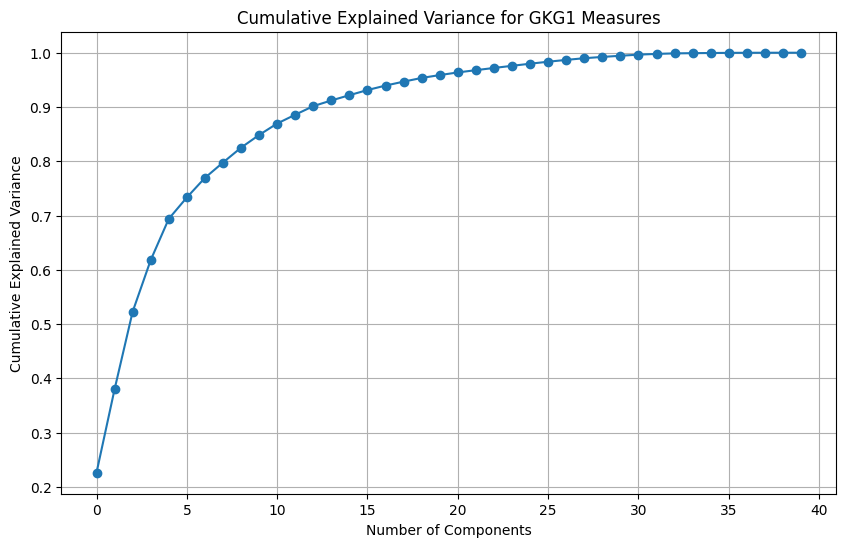

In [ ]:
plot_cumulative_explained_variance(pca_fit, 'Cumulative Explained Variance for GKG1 Measures')

In [7]:
pca_fit = PCA().fit(df_2)
# Write this to a pickle file
with open(r'../../data/processed/pca_fit_2.pkl', 'wb') as f:
    pickle.dump(pca_fit, f)

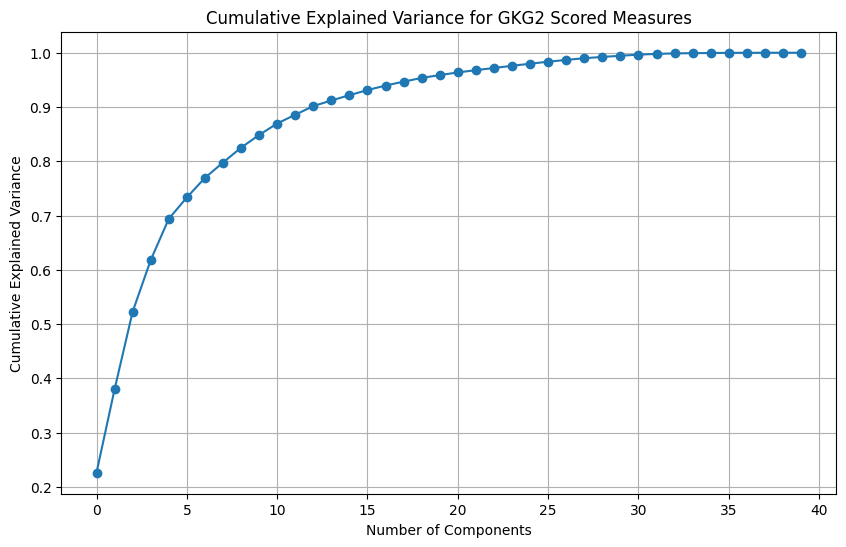

In [ ]:
plot_cumulative_explained_variance(pca_fit, 'Cumulative Explained Variance for GKG2 Scored Measures')

In [17]:
pca_fit = IncrementalPCA(batch_size=200000).fit(df)

# Write this to a pickle file
with open(r'../../data/processed/pca_fit_3.pkl', 'wb') as f:
    pickle.dump(pca_fit, f)

pca_fit.explained_variance_ratio_

array([5.77599526e-01, 2.11944827e-02, 1.35169937e-02, ...,
       5.46072287e-33, 4.64430286e-33, 3.96166352e-33])

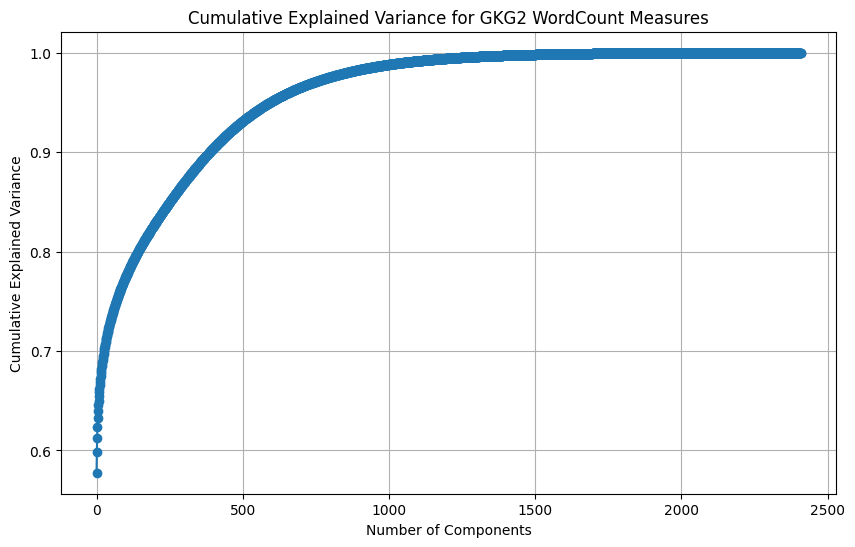

In [18]:
plot_cumulative_explained_variance(pca_fit, 'Cumulative Explained Variance for GKG2 WordCount Measures')